# Running MSA-Search NIM in Google Colab Environment

Runs MSA-Search NIM and saves result as `A3M` format file.

MSA-Search NIM: https://build.nvidia.com/colabfold/msa-search

13Aug2025

## 1.1 Set Up the Environment

In [19]:
!pip install pandas numpy seaborn matplotlib httpx "fastapi[standard]"

In [36]:
import json, os, requests, re, shutil
from google.colab import userdata

from typing import Any, Dict
from pathlib import Path

## 1.2 Set Up `output` Directory and `API_KEY`

**NOTE:** Be sure to follow the steps in the README to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [37]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # Overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

In [38]:
API_KEY = userdata.get('API_KEY')

# Prepare `output_dir` for saving files
output_dir = "/content/output"
prepare_output_directory(output_dir)

#### Define Protein Sequence and Databases to use for MSA-Search

In [ ]:
# Input your own protein sequence or use the example sequence below.
# Ensure there are no spaces or carriage returns `\n` in the sequence.
sequence = "MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQNDQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELAFHHHLCKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFSGNS"

databases = ['Uniref30_2302', 'colabfold_envdb_202108', 'PDB70_220313']

## 1.3 Set Up and Run `MSA-Search`

In [40]:
msa_search_url = "https://health.api.nvidia.com/v1/biology/colabfold/msa-search/predict"

payload = {
    "sequence": sequence,
    "databases": databases,
    "e_value": 0.0001,
    "iterations": 1,
    "max_msa_sequences": 10000,
    "run_structural_template_search": False,
    "output_alignment_formats": ["a3m"],
}

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "content-type": "application/json",
    "NVCF-POLL-SECONDS": "300",
}

# Call MSA-Search NIM
response = requests.post(msa_search_url, json=payload, headers=headers)
msa_response_dict = response.json()

with open('msa_output.json', 'w') as json_file:
    json.dump(msa_response_dict, json_file, indent=4)

## 1.4 Merge and Sort Alignments from `MSA-Search` into a Single `A3M` File

In [41]:
def parse_sequences(input_string, n, sequence):
    """
    Parse the output of alignments from the MSA-Search NIM to be used downstream

    Args:
        input_string (str): The output file of alignments in a string format
        n (int): The amount of alignments to return from the output when parsing
        sequence (str): The query sequence for alignment

    Returns:
        list: A list of alignment identifiers and sequences, starting with the query,
              where the amount of sequences is given by n
    """
    # Output is parsed to have a line for the sequence id and sequence itself so `n` returns correlates to n*2 lines
    n = n * 2

    # First, handle the `Query` block separately
    lines = input_string.strip().split('\n')

    # Now process the rest of the lines
    remaining_string = "\n".join(lines[:])

    # Regex to find blocks starting with `>` and then followed by a sequence.
    pattern = re.compile(r'\n>(.*?)\n(.*?)(?=\n>|\Z)', re.DOTALL)

    matches = pattern.finditer(remaining_string)

    output_list = []
    output_list_to_order = []

    for num_match, match in enumerate(matches):
        # The name is the first capturing group, split by tab and take the first part
        name_full = match.group(1).split('\t')[0]
        SW_score = match.group(1).split('\t')[1]

        # The sequence is the second capturing group
        sequence_raw = match.group(2).strip()
        sequence = ''.join(char for char in sequence_raw if char.isupper() or not char.isalpha())

        # Store the aligned sequence in the list of outputs by name, sequence, Smith-Waterman score
        output_list_to_order.append((f'>{name_full}', sequence, int(SW_score)))

    output_lines = output_list_to_order[:n]

    return output_lines


def write_alignments_to_a3m(alignments_data, output_file_path, description="MSA alignments"):
    """
    Write alignment data to a3M format file.

    Args:
        alignments_data: Either a list of alternating headers/sequences or a string containing alignments
        output_file_path (str): Path for the output a3M file
        description (str): Description for the file

    Returns:
        str: Path to the created a3M file
    """
    output_path = Path(output_file_path)

    # Handle both list and string input formats
    if isinstance(alignments_data, list):
        alignments_string = '\n'.join(alignments_data)
    elif isinstance(alignments_data, str):
        alignments_string = alignments_data
    else:
        raise ValueError("alignments_data must be either a list or string")

    # Count sequences for reporting
    sequence_count = alignments_string.count('>')

    print(f"Writing {sequence_count} sequences to a3M format: {output_path}")

    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            # Write the alignments
            f.write(alignments_string)

            # Ensure file ends with newline
            if not alignments_string.endswith('\n'):
                f.write('\n')

        # Verify the file was created successfully
        if output_path.exists():
            file_size = output_path.stat().st_size
            print(f"Successfully created a3M file:")
            print(f"File: {output_path}")
            print(f"Size: {file_size:,} bytes")
            print(f"Sequences: {sequence_count}")

            return str(output_path)
        else:
            raise IOError(f"Failed to create file {output_path}")

    except Exception as e:
        print(f"Error writing a3M file: {e}")
        raise


def process_msa_alignments(msa_response_dict, databases, sequence, max_sequences_per_db=10000, output_file="merged_alignments_protein.a3m"):
    """
    Process MSA alignments from multiple databases and merge them into A3M format.

    Args:
        msa_response_dict (dict): MSA response data containing alignments
        databases (list): List of database names to process
        sequence (str): Query sequence for alignment
        max_sequences_per_db (int): Maximum number of sequences to parse per database
        output_file (str): Output A3M file path

    Returns:
        tuple: (merged_alignments_protein, a3m_file_path)
            - merged_alignments_protein: List of merged alignments
            - a3m_file_path: Path to the created A3M file
    """
    all_parsed_dataset_output = []

    for num_done, database in enumerate(databases):
        print(f"Parsing results from database: {database}")

        # Pull string of alignments stored in json output for specific dataset
        a3m_dict_msa_search = msa_response_dict['alignments'][database]['a3m']['alignment']

        a3m_dict_msa_search_parsed = parse_sequences(a3m_dict_msa_search, max_sequences_per_db, sequence)

        num_sequences_aligned = (len(a3m_dict_msa_search_parsed))
        print(f"Number of sequences aligned: {num_sequences_aligned}")

        all_parsed_dataset_output.extend(a3m_dict_msa_search_parsed)

    # Sort all the alignments based off of the alignment score
    all_parsed_dataset_output.sort(key=lambda x: x[2], reverse=True)

    # Now that the alignments across all datasets are sorted, reformat each entry to name and sequence
    sorted_parsed_output_formatted = []
    for align_tuple in all_parsed_dataset_output:
        sorted_parsed_output_formatted.append(align_tuple[0])
        sorted_parsed_output_formatted.append(align_tuple[1])

    merged_alignments_protein = [f">query_sequence\n{sequence}"]
    merged_alignments_protein.extend(sorted_parsed_output_formatted)

    print(f"Total merged alignments: {len(merged_alignments_protein)}")

    # Write merged_alignments_protein to a3M format
    a3m_file_path = write_alignments_to_a3m(
        merged_alignments_protein,
        output_file,
        description=f"Merged protein alignments from MSA-Search NIM ({', '.join(databases)})"
    )

    return merged_alignments_protein, a3m_file_path


def write_filtered_a3m(alignments_data, output_file_path, max_sequences=None, min_length=None, description="Filtered MSA alignments"):
    """
    Write alignment data to a3M format with optional filtering.

    Args:
        alignments_data: String containing alignments in FASTA-like format
        output_file_path (str): Path for the output a3M file
        max_sequences (int, optional): Maximum number of sequences to include
        min_length (int, optional): Minimum sequence length (excluding gaps)
        description (str): Description for the file

    Returns:
        str: Path to the created a3M file
    """
    output_path = Path(output_file_path)

    # Parse sequences from the input data
    if isinstance(alignments_data, str):
        lines = alignments_data.strip().split('\n')
    else:
        lines = '\n'.join(alignments_data).strip().split('\n')

    sequences = []
    current_header = None
    current_sequence = ""

    for line in lines:
        line = line.strip()
        if line.startswith('>'):
            # Save previous sequence if it exists
            if current_header is not None:
                sequences.append((current_header, current_sequence))
            current_header = line
            current_sequence = ""
        else:
            current_sequence += line

    # Don't forget the last sequence
    if current_header is not None:
        sequences.append((current_header, current_sequence))

    print(f"Parsed {len(sequences)} sequences from input data")

    # Apply filters
    filtered_sequences = []

    for header, sequence in sequences:
        # Apply minimum length filter (count non-gap characters)
        if min_length is not None:
            non_gap_length = len(sequence.replace('-', '').replace('.', ''))
            if non_gap_length < min_length:
                continue

        filtered_sequences.append((header, sequence))

        # Apply maximum sequences limit
        if max_sequences is not None and len(filtered_sequences) >= max_sequences:
            break

    print(f"After filtering: {len(filtered_sequences)} sequences")
    if max_sequences:
        print(f"Max sequences limit: {max_sequences}")
    if min_length:
        print(f"Min length filter: {min_length}")

    # Write to a3M format
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            # Write sequences
            for header, sequence in filtered_sequences:
                f.write(f"{header}\n{sequence}\n")

        # Report success
        file_size = output_path.stat().st_size
        print(f"Successfully created filtered a3M file:")
        print(f"File: {output_path}")
        print(f"Size: {file_size:,} bytes")
        print(f"Sequences: {len(filtered_sequences)}")

        return str(output_path)

    except Exception as e:
        print(f"Error writing filtered a3M file: {e}")
        raise


def analyze_a3m_file(file_path):
    """
    Analyze an a3M file and provide statistics.

    Args:
        file_path (str): Path to the a3M file
    """
    file_path = Path(file_path)

    if not file_path.exists():
        print(f"File not found: {file_path}")
        return

    print(f"Analyzing a3M file: {file_path.name}")

    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Count statistics
        total_lines = len(lines)
        comment_lines = sum(1 for line in lines if line.startswith('#'))
        sequence_headers = sum(1 for line in lines if line.startswith('>'))
        sequence_lines = total_lines - comment_lines - sequence_headers

        # Calculate sequence lengths
        sequence_lengths = []
        current_sequence = ""

        for line in lines:
            line = line.strip()
            if line.startswith('#'):
                continue
            elif line.startswith('>'):
                if current_sequence:
                    sequence_lengths.append(len(current_sequence))
                current_sequence = ""
            else:
                current_sequence += line

        # Don't forget the last sequence
        if current_sequence:
            sequence_lengths.append(len(current_sequence))

        # File statistics
        file_size = file_path.stat().st_size

        print(f"File Statistics:")
        print(f"File size: {file_size:,} bytes")
        print(f"Total lines: {total_lines}")
        print(f"Comment lines: {comment_lines}")
        print(f"Sequence headers: {sequence_headers}")
        print(f"Sequence lines: {sequence_lines}")

        if sequence_lengths:
            avg_length = sum(sequence_lengths) / len(sequence_lengths)
            min_length = min(sequence_lengths)
            max_length = max(sequence_lengths)

            print(f"Sequence Statistics:")
            print(f"Number of sequences: {len(sequence_lengths)}")
            print(f"Average length: {avg_length:.1f}")
            print(f"Length range: {min_length} - {max_length}")

            # Show first sequence as example
            with open(file_path, 'r') as f:
                content = f.read()

            # Find first sequence
            lines = content.split('\n')
            for i, line in enumerate(lines):
                if line.startswith('>') and not line.startswith('#'):
                    header = line
                    sequence = ""
                    j = i + 1
                    while j < len(lines) and not lines[j].startswith('>'):
                        if not lines[j].startswith('#'):
                            sequence += lines[j].strip()
                        j += 1

                    print(f"First sequence example:")
                    print(f"Header: {header}")
                    print(f"Length: {len(sequence)}")
                    print(f"Preview: {sequence[:80]}{'...' if len(sequence) > 80 else ''}")
                    break

    except Exception as e:
        print(f"Error analyzing file: {e}")


### Parse the MSA alignment results to merge results from all datasets into a single `A3M` format file

In [42]:
merged_alignments_protein, a3m_file_path = process_msa_alignments(
    msa_response_dict,
    databases,
    sequence,
    max_sequences_per_db=10000,
    output_file="merged_alignments_protein.a3m"
    )

Parsing results from database: Uniref30_2302
Number of sequences aligned: 100
Parsing results from database: colabfold_envdb_202108
Number of sequences aligned: 100
Parsing results from database: PDB70_220313
Number of sequences aligned: 88
Total merged alignments: 577
Writing 289 sequences to a3M format: merged_alignments_protein.a3m
Successfully created a3M file:
File: merged_alignments_protein.a3m
Size: 81,161 bytes
Sequences: 289


### Download the `A3M` file to your local machine

In [44]:
from google.colab import files
files.download("merged_alignments_protein.a3m")
files.download("msa_output.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1.5 Analyze the `A3M` Format File

In [45]:
# Analyze all created a3M files
print("=" * 60)
print("A3M FILE ANALYSIS")
print("=" * 60)

files_to_analyze = [
    "merged_alignments_protein.a3m",
]

for file_name in files_to_analyze:
    if Path(file_name).exists():
        analyze_a3m_file(file_name)
        print("-" * 40)
    else:
        print(f"File not found: {file_name}")
        print("-" * 40)

A3M FILE ANALYSIS
Analyzing a3M file: merged_alignments_protein.a3m
File Statistics:
File size: 81,161 bytes
Total lines: 578
Comment lines: 0
Sequence headers: 289
Sequence lines: 289
Sequence Statistics:
Number of sequences: 289
Average length: 265.0
Length range: 265 - 265
First sequence example:
Header: >query_sequence
Length: 265
Preview: MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLT...
----------------------------------------


## 1.6 Visualize the MSA Results

In [46]:
# Read in the MSA output
with open('merged_alignments_protein.a3m', 'r') as file:
    msa_output = file.read()
    msa_output = msa_output.split('\n')
    seq_list = msa_output[1::2]
    seq_names = msa_output[::2]
    #remove '>' from seq_names
    seq_names = [name.replace('>', '') for name in seq_names]

In [47]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


BLUE = (120/255, 94/255, 240/255) # `indigo` from IBM colorblind friendly
GREEN = (118/255, 185/255, 0/255)


def GetConsensus(msa):
    """Calculate per-index similarity of all strings compared to the baseline (first string)."""
    if not msa or len(msa) < 2:
        return []

    baseline = msa[0]
    max_length = max(len(seq) for seq in msa)
    consensus = []

    # Analyze each position
    for pos in range(max_length):
        baseline_char = baseline[pos] if pos < len(baseline) else '-'

        # Count matches with baseline at this position
        matches = 0
        total_strings = 0

        for seq in msa[1:]:
            if pos < len(seq):
                seq_char = seq[pos]
                if seq_char != '-' and baseline_char != '-':
                    if seq_char == baseline_char:
                        matches += 1
                    total_strings += 1

        # Calculate similarity percentage for this position
        similarity = (matches / total_strings * 100) if total_strings > 0 else 0
        consensus.append({
            'position': pos,
            'baseline_char': baseline_char,
            'similarity_percent': similarity,
            'matches': matches,
            'total_comparisons': total_strings
        })

    return consensus


def ConsensusHistogram(msa,
                       color=GREEN,
                       start=None, end=None,
                       tick_fontsize=8,
                       label_fontsize=12,
                       title_fontsize=14,
                       ):
    """Create histogram of consensus frequencies using seaborn with customizable fonts."""
    if not msa:
        return None

    # Slice MSA if start/end specified
    if start is not None or end is not None:
        msa = [seq[start:end] for seq in msa]

    # Transpose to get columns (positions)
    positions = list(zip(*msa))

    # Calculate consensus frequency at each position
    consensus_results = GetConsensus(msa)
    consensus_freqs = [item['similarity_percent'] for item in consensus_results]

    # Create the plot
    plt.figure(figsize=(12, 4))

    # Use seaborn for better styling
    sns.set_style("whitegrid")

    # Create the histogram
    ax = sns.barplot(x=list(range(len(consensus_freqs))),
                     y=consensus_freqs,
                     color=color,
                     alpha=0.9,
                     edgecolor='white',
                     )

    # Remove space between bars
    for patch in ax.patches:
        current_width = patch.get_width()
        new_width = 1.0  # Set width to 1.0 to eliminate gaps
        diff = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * .5) # Adjust x-position to center the bar


    # Automatically set major x-axis ticks based on figure size
    num_positions = len(consensus_freqs)
    if num_positions > 0:
        # Calculate optimal number of ticks based on figure width
        # Aim for roughly 8-12 ticks across the figure
        optimal_ticks = min(12, max(5, num_positions // 10))

        # Calculate tick positions
        tick_positions = np.linspace(1, num_positions, optimal_ticks, dtype=int)

        # Set x-axis ticks and labels
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{pos}' for pos in tick_positions], fontsize=tick_fontsize)

    # Customize tick marks
    ax.tick_params(axis='both', labelsize=tick_fontsize)

    # Customize labels with specified font sizes
    ax.set_xlabel('Sequence Position', fontsize=label_fontsize)
    ax.set_ylabel('Consensus Frequency', fontsize=label_fontsize)
    ax.set_title('Consensus Frequency by Position Across All MSA Sequences', fontsize=title_fontsize, fontweight='bold')

    # Add grid with custom styling
    ax.grid(True, alpha=0.3, linestyle='--')

    # Adjust layout
    plt.tight_layout()

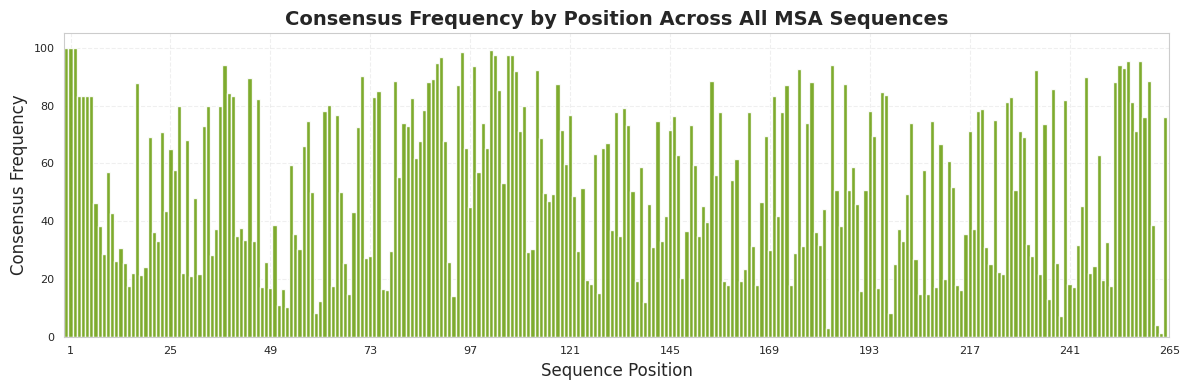

In [48]:
ConsensusHistogram(seq_list)

